In [1]:
import io
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import nltk
import re
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
!pip install scikit-multilearn
!pip install wordcloud


from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv(r"/content/drive/My Drive/practicum2/train.csv")
train_df.head()

train_df = train_df.drop_duplicates()
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print(train_df.shape)
print(train_df.columns)

(159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [5]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train_df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
# Precompile regex patterns
pattern2 = re.compile(r"[^a-zA-Z0-9\s]")
pattern3 = re.compile(r"\d")
pattern4 = re.compile(r"\s+")
pattern5 = re.compile(r"http\S+|www\S+|https\S+")
pattern6 = re.compile(r"\n")

def remove_pattern(input_txt):

    input_txt = pattern2.sub('', input_txt)   # Remove special characters
    input_txt = pattern3.sub('', input_txt)   # Remove numbers
    input_txt = pattern4.sub(' ', input_txt).strip()   # Remove extra white spaces
    input_txt = pattern5.sub('', input_txt)   # Remove URLs
    input_txt = pattern6.sub('', input_txt)   # Remove newline characters

    return input_txt

train_df['comment_text'] = train_df['comment_text'].apply(remove_pattern)


In [8]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0,0,0,0,0,0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,More I cant make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0


In [9]:
# Lemmatization object
wLemmatizer = WordNetLemmatizer()

# Function to perform lemmatization and remove stopwords
def lemmatize_and_remove_stopwords(text):
    stopWords = set(stopwords.words('english'))
    swRemoved = [word for word in text.split() if word.lower() not in stopWords and len(word) > 2]
    words = [wLemmatizer.lemmatize(word) for word in swRemoved]
    return ' '.join(words)

# Applying the lemmatization function to the 'comment_text' column
train_df['comment_text'] = train_df['comment_text'].apply(lemmatize_and_remove_stopwords)


In [10]:
train_df[['comment_text']].head(10)

,comment_text
0,Explanation edits made username Hardcore Metal...
1,Daww match background colour seemingly stuck T...
2,Hey man really trying edit war guy constantly ...
3,cant make real suggestion improvement wondered...
4,sir hero chance remember page thats
5,Congratulations well use tool well talk
6,COCKSUCKER PISS AROUND WORK
7,vandalism Matt Shirvington article reverted Pl...
8,Sorry word nonsense offensive Anyway intending...
9,alignment subject contrary DuLithgow


In [11]:
def count_unique_words(dataset_column):
    corpus = " ".join(dataset_column)
    tokens = corpus.split()
    unique_words = set(tokens)
    return len(unique_words)

unique_word_count = count_unique_words(train_df['comment_text'])
print("Number of unique words in the 'comment_text' column:", unique_word_count)

Number of unique words in the 'comment_text' column: 252190


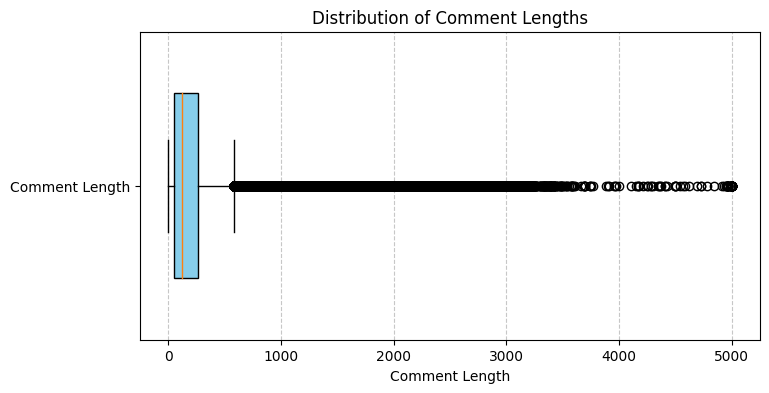

In [12]:
comment_lengths = np.array([len(comment) for comment in train_df['comment_text']])
# Create a horizontal box plot to visualize the distribution of comment lengths
plt.figure(figsize=(8, 4))
boxplot = plt.boxplot(comment_lengths, vert=False, widths=0.6, labels=['Comment Length'], patch_artist=True)

# Add some custom styling to the boxplot
box_colors = ['skyblue']
for box, color in zip(boxplot['boxes'], box_colors):
    box.set_facecolor(color)
    box.set_edgecolor('black')

plt.xlabel('Comment Length')
plt.title('Distribution of Comment Lengths')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [13]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

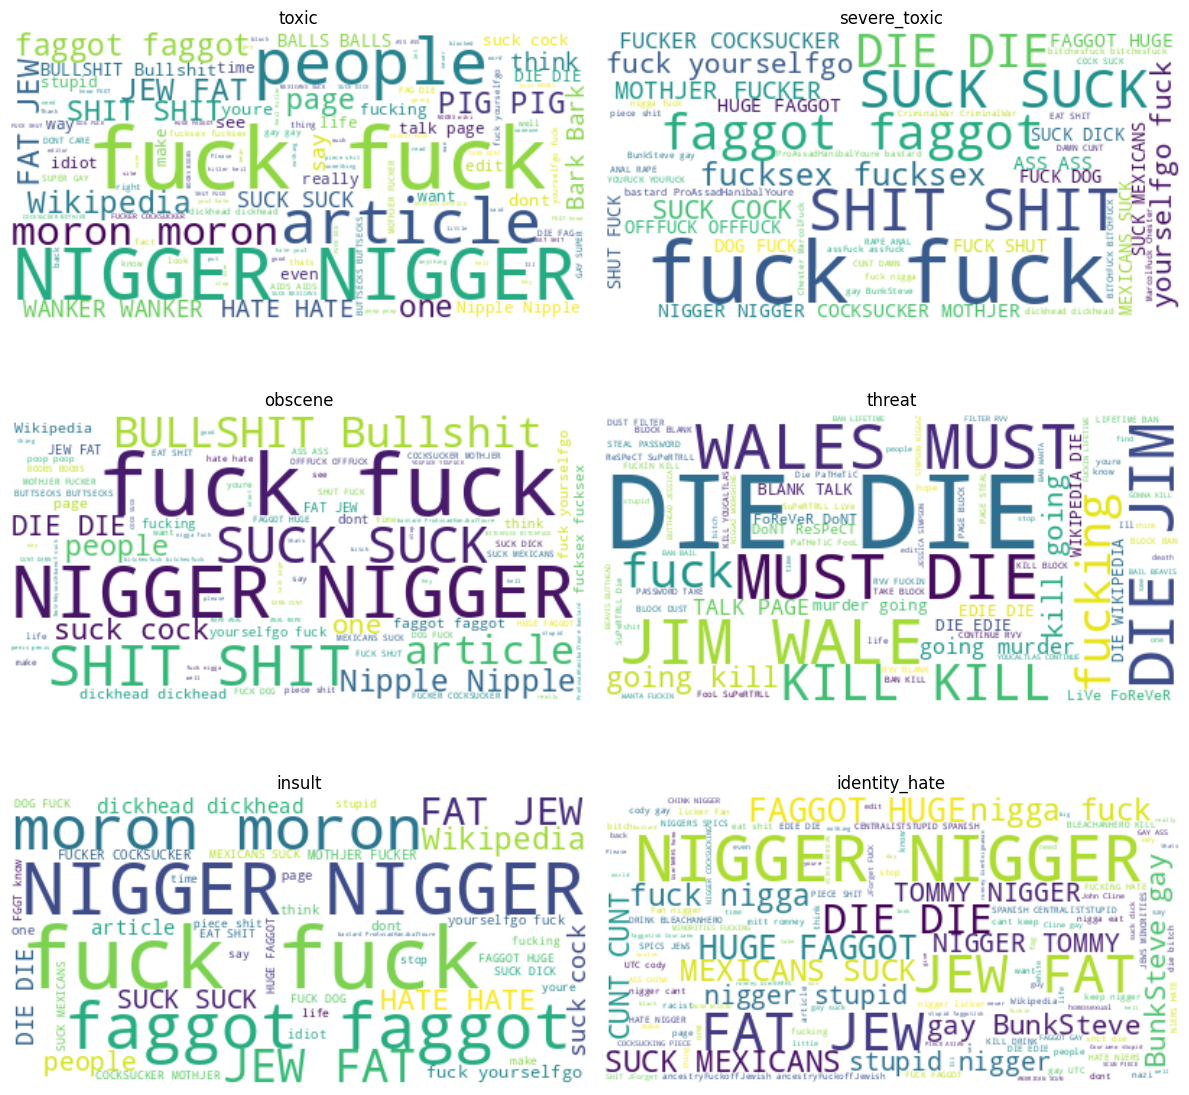

In [14]:
from wordcloud import WordCloud

# Define the binary classes
binary_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Iterate over the binary classes and create word clouds for each subplot
for i, column in enumerate(binary_classes):
    # Select the comments based on the condition
    comments = train_df[train_df[column] == 1]['comment_text']

    # Concatenate the comments
    concatenated_text = ' '.join(comments)

    # Create the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(concatenated_text)

    # Plot the word cloud on the corresponding subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(column)
    axs[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


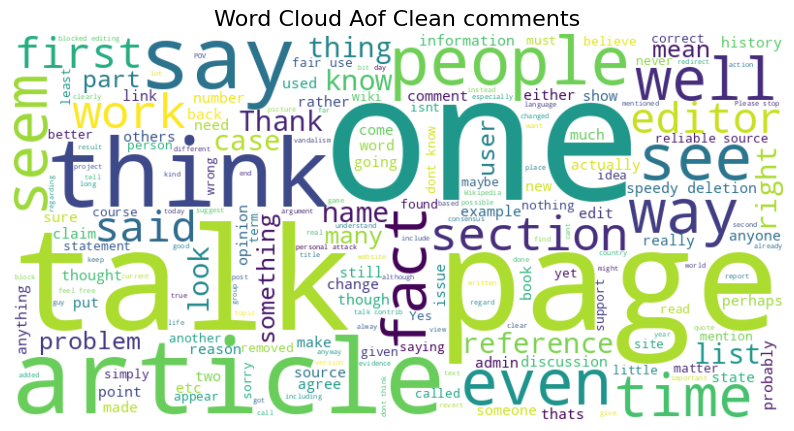

In [15]:
LABEL_COLUMNS = train_df.columns.tolist()[2:]

NonToxicComments = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]


text_data = NonToxicComments['comment_text'].str.cat(sep=' ')

# Create a WordCloud Aobject
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Clean comments", fontsize=16)
plt.axis('off')
plt.show()

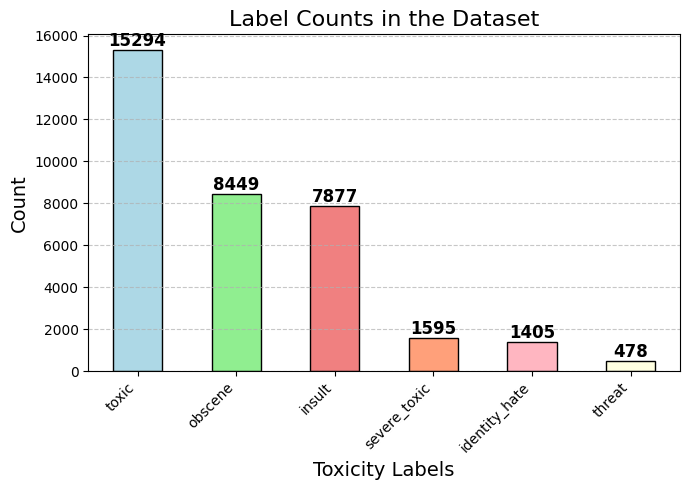

In [16]:
# Calculate the count of each label
label_counts = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Sort the label counts in ascending order
label_counts_sorted = label_counts.sort_values(ascending=False)

# Create a custom color palette for each bar
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightyellow']

# Plot the label counts in a bar plot in ascending order with labels on top and different colors
plt.figure(figsize=(7, 5))
ax = label_counts_sorted.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Label Counts in the Dataset', fontsize=16)
plt.xlabel('Toxicity Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the actual value of each bar on top of the bar
for i, v in enumerate(label_counts_sorted):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


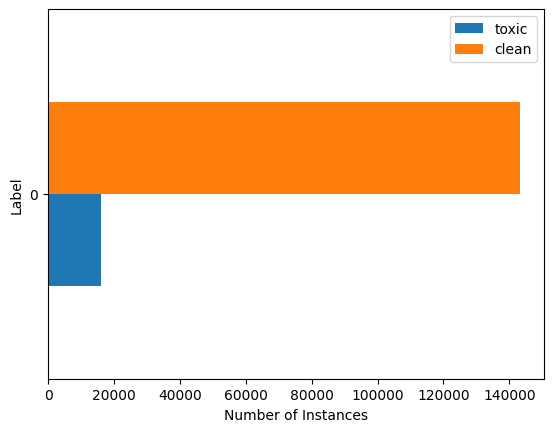

In [17]:
LABEL_COLUMNS = train_df.columns.tolist()[2:]
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

ax = pd.DataFrame(dict(
    toxic=[len(train_toxic)],
    clean=[len(train_clean)]
)).plot(kind='barh')


# Add labels and title
ax.set_xlabel('Number of Instances')
ax.set_ylabel('Label')

plt.show()

In [18]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(16_000)
])
train_df.shape

(32225, 8)

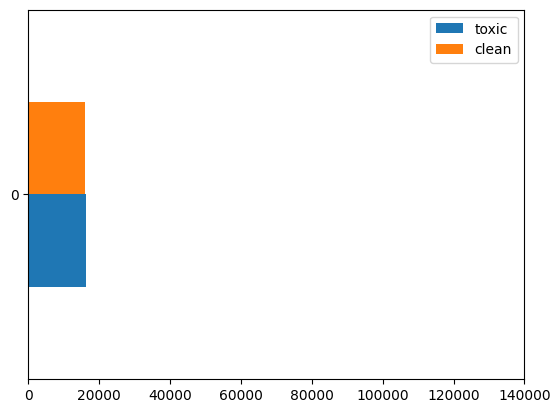

In [19]:
LABEL_COLUMNS = train_df.columns.tolist()[2:]
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

ax = pd.DataFrame(dict(
    toxic=[len(train_toxic)],
    clean=[len(train_clean)]
)).plot(kind='barh')

# Set the x-axis limits
ax.set_xlim(0, 140000)


plt.show()

## Binary Relevance

In [20]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)

# Vectorizing the input text
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Creating the binary relevance classifier using Logistic Regression
classifier1 = BinaryRelevance(LogisticRegression(class_weight='balanced'))

# Training the classifier on the training set
classifier1.fit(X_train_vec, y_train)

# Predicting the labels for the test set
y_pred = classifier1.predict(X_test_vec)

# Printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3073
           1       0.32      0.82      0.46       305
           2       0.81      0.81      0.81      1703
           3       0.32      0.67      0.43        99
           4       0.66      0.78      0.72      1605
           5       0.35      0.69      0.47       301

   micro avg       0.71      0.82      0.76      7086
   macro avg       0.56      0.77      0.63      7086
weighted avg       0.76      0.82      0.78      7086
 samples avg       0.33      0.39      0.34      7086



In [24]:
from sklearn.metrics import accuracy_score

# Convert y_pred to dense array
y_pred_dense = y_pred.toarray()

# Calculating accuracy for each label
label_accuracies = []
for i, label in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[label], y_pred_dense[:, i])
    label_accuracies.append((label, accuracy))

# Calculate and print the overall accuracy
overall_accuracy = sum(acc for _, acc in label_accuracies) / len(label_accuracies)
print("\nLabel-wise Accuracies:")
for label, accuracy in label_accuracies:
    print(f"{label}: {accuracy:.4f}")

print("\nOverall Accuracy:", overall_accuracy)



Label-wise Accuracies:
toxic: 0.8753
severe_toxic: 0.9099
obscene: 0.9005
threat: 0.9733
insult: 0.8473
identity_hate: 0.9266

Overall Accuracy: 0.9054822860098266


## Classifier Chains

In [27]:
from sklearn.multioutput import ClassifierChain

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)

# Vectorizing the input text with limited features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Creating the classifier chain using Logistic Regression
classifier2 = ClassifierChain(LogisticRegression())

# Training the classifier on the training set
classifier2.fit(X_train_vec, y_train)

# Predicting the labels for the test set
y_pred = classifier2.predict(X_test_vec)

# Printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3073
           1       0.59      0.22      0.32       305
           2       0.89      0.71      0.79      1703
           3       0.76      0.13      0.22        99
           4       0.75      0.61      0.67      1605
           5       0.81      0.20      0.32       301

   micro avg       0.85      0.69      0.76      7086
   macro avg       0.78      0.45      0.53      7086
weighted avg       0.84      0.69      0.75      7086
 samples avg       0.37      0.34      0.34      7086



In [30]:
from sklearn.metrics import accuracy_score

# Predicting the labels for the test set
y_pred = classifier2.predict(X_test_vec)

# Calculating accuracy for each label
label_accuracies = []
for i, label in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[label], y_pred[:, i])
    label_accuracies.append((label, accuracy))

# Calculate and print the overall accuracy
overall_accuracy = sum(acc for _, acc in label_accuracies) / len(label_accuracies)
print("\nLabel-wise Accuracies:")
for label, accuracy in label_accuracies:
    print(f"{label}: {accuracy:.4f}")

print("\nOverall Accuracy:", overall_accuracy)



Label-wise Accuracies:
toxic: 0.8698
severe_toxic: 0.9558
obscene: 0.9001
threat: 0.9860
insult: 0.8523
identity_hate: 0.9604

Overall Accuracy: 0.9207395914145332


## Label Powerset

In [31]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.utils.class_weight import compute_sample_weight

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)

# Vectorizing the input text with limited features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Manually calculate class weights for each label separately
class_weights = []
for col in y_train.columns:
    sample_weight = compute_sample_weight('balanced', y_train[col])
    class_weights.append(np.mean(sample_weight))

# Creating the Label Powerset classifier using Logistic Regression with custom class weights
classifier3 = LabelPowerset(LogisticRegression(class_weight={i: w for i, w in enumerate(class_weights)}))

# Training the classifier on the training set
classifier3.fit(X_train_vec, y_train)

# Predicting the labels for the test set
y_pred = classifier3.predict(X_test_vec)

# Printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      3073
           1       0.49      0.13      0.21       305
           2       0.88      0.64      0.74      1703
           3       0.67      0.06      0.11        99
           4       0.78      0.56      0.65      1605
           5       0.70      0.12      0.21       301

   micro avg       0.86      0.62      0.72      7086
   macro avg       0.74      0.38      0.46      7086
weighted avg       0.84      0.62      0.70      7086
 samples avg       0.34      0.30      0.30      7086



In [33]:
from sklearn.metrics import accuracy_score

# Predicting the labels for the test set
y_pred = classifier3.predict(X_test_vec)

# Convert y_pred to dense array
y_pred_dense = y_pred.toarray()

# Calculating accuracy for each label
label_accuracies = []
for i, label in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[label], y_pred_dense[:, i])
    label_accuracies.append((label, accuracy))

# Calculate and print the overall accuracy
overall_accuracy = sum(acc for _, acc in label_accuracies) / len(label_accuracies)
print("\nLabel-wise Accuracies:")
for label, accuracy in label_accuracies:
    print(f"{label}: {accuracy:.4f}")

print("\nOverall Accuracy:", overall_accuracy)



Label-wise Accuracies:
toxic: 0.8483
severe_toxic: 0.9525
obscene: 0.8821
threat: 0.9851
insult: 0.8495
identity_hate: 0.9566

Overall Accuracy: 0.9123351435221102


## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=330)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Computing class weights based on inverse class frequency
class_weights = len(y_train) / np.sum(y_train, axis=0)

# Creating the KNeighborsClassifier with class weights
classifier4 = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Training the classifier on the training set
classifier4.fit(X_train_vec, y_train)

# Predicting the labels for the test set
y_pred = classifier4.predict(X_test_vec)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69      3073
           1       0.38      0.20      0.26       305
           2       0.83      0.53      0.65      1703
           3       0.46      0.19      0.27        99
           4       0.71      0.47      0.57      1605
           5       0.58      0.25      0.34       301

   micro avg       0.76      0.52      0.62      7086
   macro avg       0.62      0.37      0.46      7086
weighted avg       0.75      0.52      0.61      7086
 samples avg       0.26      0.24      0.24      7086



In [41]:
from sklearn.metrics import accuracy_score

# Predicting the labels for the test set
y_pred = classifier4.predict(X_test_vec)

# Calculating accuracy for each label
label_accuracies = []
for i, label in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[label], y_pred[:, i])
    label_accuracies.append((label, accuracy))

# Calculate and print the overall accuracy
overall_accuracy = sum(acc for _, acc in label_accuracies) / len(label_accuracies)
print("\nLabel-wise Accuracies:")
for label, accuracy in label_accuracies:
    print(f"{label}: {accuracy:.4f}")

print("\nOverall Accuracy:", overall_accuracy)



Label-wise Accuracies:
toxic: 0.7365
severe_toxic: 0.9465
obscene: 0.8475
threat: 0.9842
insult: 0.8196
identity_hate: 0.9564

Overall Accuracy: 0.8817688130333593
